In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [2]:
sm = ps.StanModel(file="stan_files/nn_refpoints_constrainedZ.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7e86a1488a72a5922ff4466b35dab61 NOW.


In [3]:
M = 1000
Z = 10*npr.rand(2,M)
X = np.zeros((3,M))
X[0] = np.cos(Z[0])*np.cos(Z[1])
X[1] = np.cos(Z[0])*np.sin(Z[1])
X[2] = np.sin(Z[0])

idx = X[2]>0
X = X[:,idx]
Z = Z[:,idx]
X += 0.1*npr.rand(*np.shape(X))
Nobs = np.shape(Z)[1]

### Local linear embedding for reference points:

In [4]:
n_ref = 0
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
X_embedded = embedding.fit_transform(X.transpose()).transpose()

In [5]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
X_ref = X[:,ref_points]
Z_ref = X_embedded[:,ref_points]
X_train = X[:,train]

In [6]:
for i in range(np.shape(Z_ref)[1]) :
    Z_ref[:,i] /= np.linalg.norm(Z_ref[:,i])

In [7]:
n_in = np.shape(X_embedded)[0]
n_h = 20
n_out = np.shape(X)[0]

model = nn.Sequential(nn.Linear(n_in, n_h),
                      nn.Tanh(),
                      nn.Linear(n_h, n_out))

In [8]:
data = dict(Nobs=Nobs, in_dim=np.shape(Z)[0], out_dim=np.shape(X)[0], hidden_dim=n_h,
            n_ref=np.shape(X_ref)[1], X=X_train, X_ref=X_ref, Z_ref=Z_ref)

### Run Stan:

In [9]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=10, chains=10,
                   init="random", iter=1_000)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


79.86 minutes to run
Inference for Stan model: anon_model_b7e86a1488a72a5922ff4466b35dab61.
10 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=5000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]              -0.07    0.38   0.96  -1.77  -0.84  -0.19   0.68   1.62      6    2.5
Z[2,1]              -0.16    0.35   0.87   -1.9  -0.79  -0.17   0.48   1.53      6   3.06
Z[3,1]              -0.01    0.43   1.07  -2.06  -0.92   0.16   0.76   1.87      6    2.7
Z[4,1]              -0.14    0.41   0.99  -2.54  -0.72   0.02   0.57   1.47      6   3.12
Z[5,1]               0.41    0.29   0.83   -1.2  -0.11    0.4   1.01    2.1      8   2.22
Z[6,1]               0.66    0.29   0.83  -1.66   0.27   0.72   1.17   2.06      8   1.92
Z[7,1]               0.09    0.31   0.75  -1.74  -0.33   0.09   0.67   1.27      6   2.66
Z[8,1]              -0.82    0.28   0.83  -2.17  -1.39  -0.91  -0.43   

In [10]:
trace = fit.extract()
n_samples = np.shape(trace['Z'])[0]
n_latent = np.shape(trace['Z'])[1]

### Traceplots of latent variables:

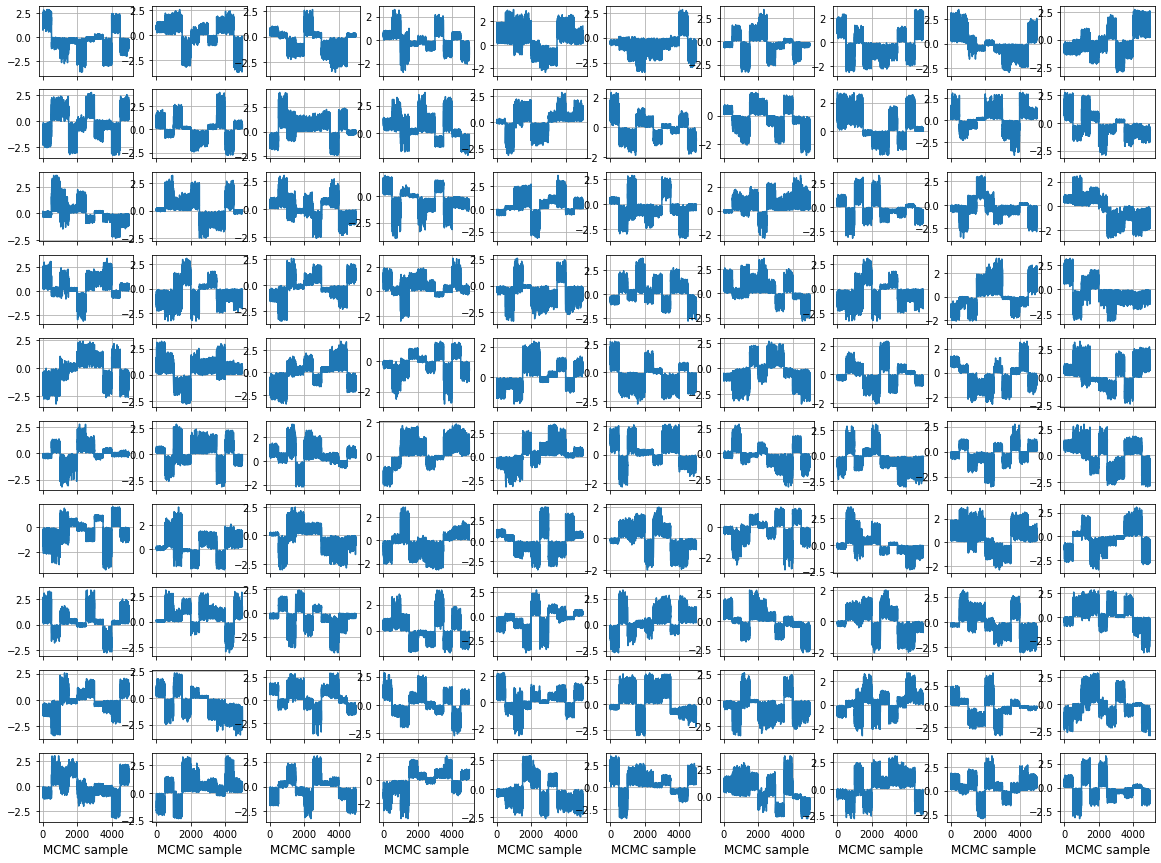

In [11]:
plt.figure(figsize=(20,15))
idx = npr.choice(n_latent,100).reshape(10,10)

for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.plot(trace['Z'][:,idx[i,j],0])
        if i < 9 : plt.xticks(alpha=0)
        if i == 9 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.show()

### Loss:

In [12]:
normedZ = np.zeros((np.shape(trace['Z'])))
for i in range(np.shape(normedZ)[0]) :
    for j in range(np.shape(normedZ)[1]) :
        for k in range(np.shape(normedZ)[2]) :
            normedZ[i,j,k] = trace['Z'][i,j,k]/np.linalg.norm(trace['Z'][i,j])

In [13]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))

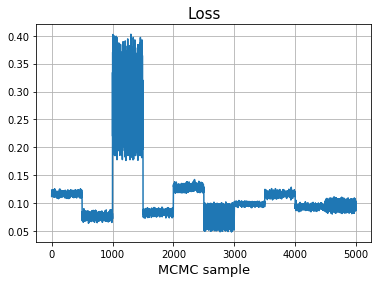

In [14]:
loss = np.zeros(n_samples)
for i in range(n_samples) :
    loss[i] = L2_loss(X_train.transpose(), normedZ[i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True);

### Pairwise distances:

In [15]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in range(50) :
    for j in range(50) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['Z'][k,i]-trace['Z'][k,j])

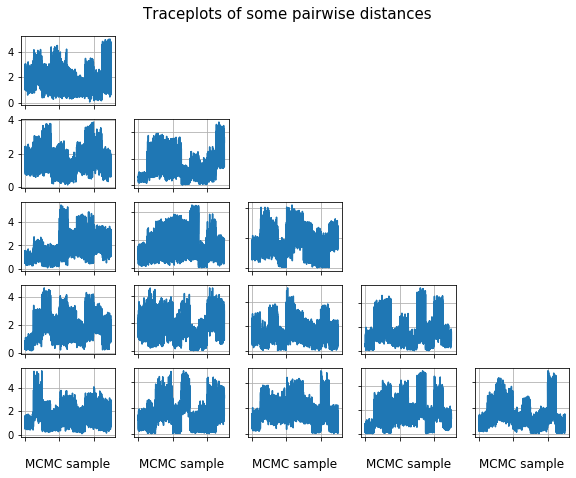

In [19]:
k_max = 50
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(6):
    for j in range(6):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 6 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 5 : plt.xlabel("MCMC sample", fontsize=12)
            if j > 0 : plt.yticks(alpha=0)
plt.suptitle("Traceplots of some pairwise distances", fontsize=15, x=0.31,y=0.83)
plt.savefig('plots/pw_dist_constrainedW1_norefpoints.pdf', dpi=2000, bbox_inches='tight');

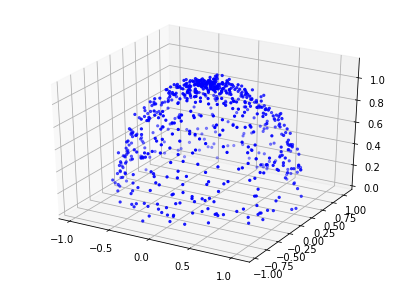

In [30]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=X[0], ys=X[1], zs=X[2], zdir='z', s=5, c=None, depthshade=True, color="blue")
plt.savefig('plots/sphere.pdf', dpi=1000, bbox_inches='tight');